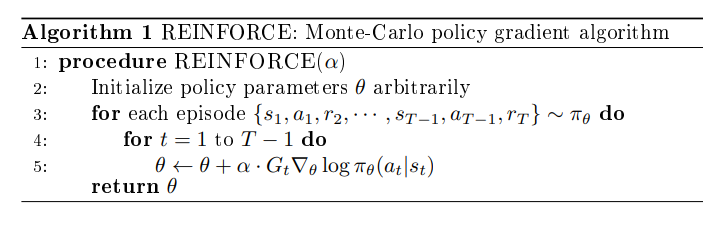

In this algorithm, instead of using actual returns(Gt) from the environment to estimate Qπθ (s, a), we can
train another state-action value function Qw(s, a) to approximate the policy gradient. This approach is
known as actor-critic where the Qw function is the critic. Essentially, the critic does policy evaluation
and the actor does policy improvement. So, with some slight changes in this implementation(i.e adding another neural net to estimate state-action values), we can get actor-critic algorithm and the update rules are:

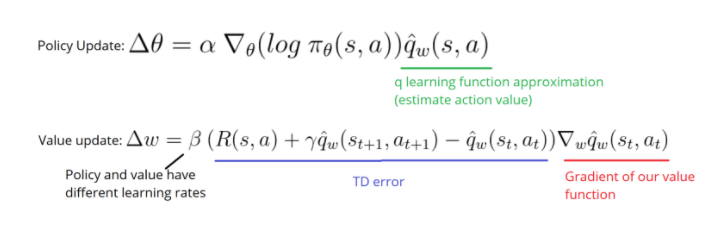

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_env = gym.make("CartPole-v1")
test_env = gym.make("CartPole-v1")

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout(self.fc1(x))
        x = F.relu(x)

        x = self.fc2(x)
        return x

In [ ]:
def init_parameters(p):
    if type(p) == nn.Linear:
        nn.init.xavier_normal_(p.weight)
        p.bias.data.fill_(0)

In [ ]:
def train(env, policy, gamma, opt):
    policy.train()
    ep_reward = 0
    rewards = []
    log_prob_actions = []
    state = env.reset()
    done = False

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        actions = policy(state)
        actions_softmax = F.softmax(actions, dim=-1)

        dist = distributions.Categorical(actions_softmax)
        action = dist.sample()
        log_prob_a = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())
        rewards.append(reward)
        log_prob_actions.append(log_prob_a)
        ep_reward += reward

    log_prob_actions = torch.cat(log_prob_actions).to(device)
    returns = get_returns(rewards, gamma)

    loss = update_policy(returns, log_prob_actions, opt)
    return loss, ep_reward

In [ ]:
def get_returns(rewards, gamma):
    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    
    returns = torch.tensor(returns).to(device)
    returns = (returns - returns.mean()) / returns.std()
    return returns

In [ ]:
def update_policy(returns, log_prob_actions, opt):
    returns.detach_()
    loss = - (returns * log_prob_actions).sum()

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    return loss.item()

In [ ]:
def evaluate(env, policy):
    policy.eval()
    ep_reward = 0
    state = env.reset()
    done = False

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            actions = policy(state)
            action = torch.argmax(actions).item()

        state, reward, done, _ = env.step(action)
        ep_reward += reward

    return ep_reward

In [ ]:
episodes = 501
gamma = 0.99
input_size = train_env.observation_space.shape[0]
hidden_size = 128
output_size = train_env.action_space.n
lr = 1e-3

In [ ]:
policy = Net(input_size, hidden_size, output_size)
policy.apply(init_parameters)
policy.to(device)
opt = torch.optim.RMSprop(policy.parameters(), lr)

In [ ]:
losses = []
train_rewards = []
test_rewards = []

In [ ]:
for ep in range(episodes):
    loss, train_reward = train(train_env, policy, gamma, opt)
    test_reward = evaluate(test_env, policy)
    
    losses.append(loss)
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    if ep % 50 == 0:
        l = sum(losses) / len(losses)
        trr = sum(train_rewards) / len(train_rewards)
        ter = sum(test_rewards) / len(test_rewards)
        print(f"episode: {ep} | loss: {l:.4f} | train_reward: {trr} | test_reward: {ter}")

        losses = []
        train_rewards = []
        test_rewards = []

episode: 0 | loss: 0.0855 | train_reward: 17.0 | test_reward: 43.0
episode: 50 | loss: -0.0619 | train_reward: 29.88 | test_reward: 108.74
episode: 100 | loss: -0.6208 | train_reward: 49.88 | test_reward: 164.1
episode: 150 | loss: -0.7157 | train_reward: 64.48 | test_reward: 240.34
episode: 200 | loss: -0.2615 | train_reward: 87.88 | test_reward: 254.74
episode: 250 | loss: -0.2486 | train_reward: 126.86 | test_reward: 441.46
episode: 300 | loss: -1.1697 | train_reward: 196.34 | test_reward: 477.5
episode: 350 | loss: -1.0221 | train_reward: 269.54 | test_reward: 499.84
episode: 400 | loss: -1.7068 | train_reward: 321.66 | test_reward: 498.76
episode: 450 | loss: -1.2517 | train_reward: 300.44 | test_reward: 491.64
episode: 500 | loss: 0.1503 | train_reward: 363.52 | test_reward: 499.56
